<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-importance-from-from-linear-model" data-toc-modified-id="Feature-importance-from-from-linear-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature importance from from linear model</a></span><ul class="toc-item"><li><span><a href="#Train-the-model-and-get-reference-score" data-toc-modified-id="Train-the-model-and-get-reference-score-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train the model and get reference score</a></span></li><li><span><a href="#Get-random-permutation-scores-and-compute-feature-importance" data-toc-modified-id="Get-random-permutation-scores-and-compute-feature-importance-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Get random permutation scores and compute feature importance</a></span></li></ul></li><li><span><a href="#With-embeddings" data-toc-modified-id="With-embeddings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>With embeddings</a></span><ul class="toc-item"><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Get-feature-importance" data-toc-modified-id="Get-feature-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Get feature importance</a></span></li></ul></li><li><span><a href="#Neural-net-with-hidden-layer-and-embeddings" data-toc-modified-id="Neural-net-with-hidden-layer-and-embeddings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Neural net with hidden layer and embeddings</a></span><ul class="toc-item"><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Evaluate-feature-importance" data-toc-modified-id="Evaluate-feature-importance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Evaluate feature importance</a></span></li></ul></li><li><span><a href="#Compare-feature-importances" data-toc-modified-id="Compare-feature-importances-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compare feature importances</a></span></li><li><span><a href="#Throw-away-&quot;useless&quot;-features" data-toc-modified-id="Throw-away-&quot;useless&quot;-features-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Throw away "useless" features</a></span></li></ul></div>

# Feature importance

The skill of our models certainly increases with auxiliary variables. Of course we would like to know which of the 38 variables we added actually helped the predictions.

Random permutation importance gives us some insight. For this we randomly permute one feature at a time from the test set and evaluate the decrease in skill.


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib inline
from nn_src.imports import *
from nn_src.utils import get_datasets

In [5]:
#DATA_DIR = '/Users/stephanrasp/data/'
DATA_DIR = '/scratch/srasp/ppnn_data/'

In [7]:
aux_train_set, aux_test_set = get_datasets(DATA_DIR, 'aux_15_16.pkl', ['2015-01-01', '2016-01-01'], aux=True)

In [9]:
n_features = aux_train_set.features.shape[1]; n_features

40

## Feature importance from from linear model

### Train the model and get reference score

In [14]:
fc_aux = build_fc_model(n_features, 2, compile=True, lr=0.02)

In [15]:
fc_aux.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 82        
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [18]:
fc_aux.fit(aux_train_set.features, aux_train_set.targets, 1024, 30, verbose=0)

In [19]:
# Get the reference score from the last model we trained
ref_score = fc_aux.evaluate(aux_test_set.features, aux_test_set.targets, 4096, 0); ref_score

0.9154892221673301

### Get random permutation scores and compute feature importance

In [20]:
def eval_shuf(m, idx, emb=False):
    x_shuf = aux_test_set.features.copy()
    x_shuf[:, idx] = np.random.permutation(x_shuf[:, idx])
    x = [x_shuf, aux_test_set.cont_ids] if emb else x_shuf
    return m.evaluate(x, aux_test_set.targets, 4096, 0)

In [47]:
def perm_imp(m):
    scores = [eval_shuf(m, i) for i in range(len(aux_test_set.feature_names))]
    fimp = np.array(scores) - ref_score
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = aux_test_set.feature_names; df['Importance'] = fimp
    return df

In [48]:
fimp_fc_aux = perm_imp(fc_aux)

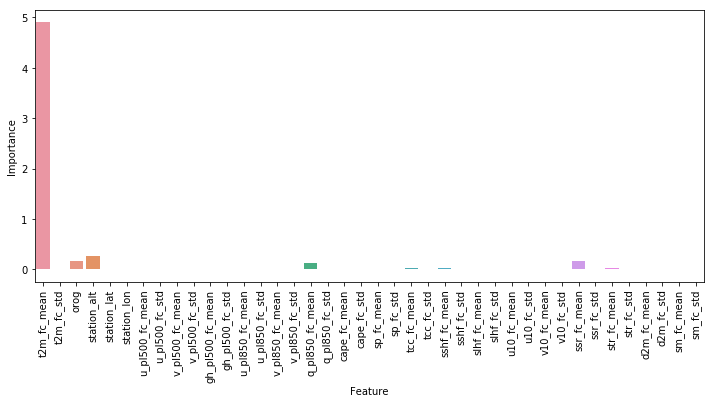

In [53]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_fc_aux, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

## With embeddings

### Train the model

In [54]:
emb_size = 2
max_id = int(np.max([aux_train_set.cont_ids.max(), aux_test_set.cont_ids.max()]))
max_id

536

In [55]:
fc_aux_emb = build_emb_model(n_features, 2, [], emb_size, max_id, compile=True, lr=0.02)

In [56]:
fc_aux_emb.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
               epochs=30, batch_size=1024, verbose=0);

In [57]:
ref_score = fc_aux_emb.evaluate([aux_test_set.features, aux_test_set.cont_ids], aux_test_set.targets, 4096, 0)
ref_score

0.878391637385286

### Get feature importance

In [60]:
def perm_imp_emb(m, ref):
    scores = [eval_shuf(m, i, True) for i in range(len(aux_test_set.feature_names))]
    ids_shuf = np.random.permutation(aux_test_set.cont_ids)
    scores += [m.evaluate([aux_test_set.features, ids_shuf], aux_test_set.targets, 4096, 0)]
    fimp = np.array(scores) - ref
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = aux_test_set.feature_names + ['Embedding']; df['Importance'] = fimp
    return df

In [62]:
fimp_fc_aux_emb = perm_imp_emb(fc_aux_emb, ref_score)

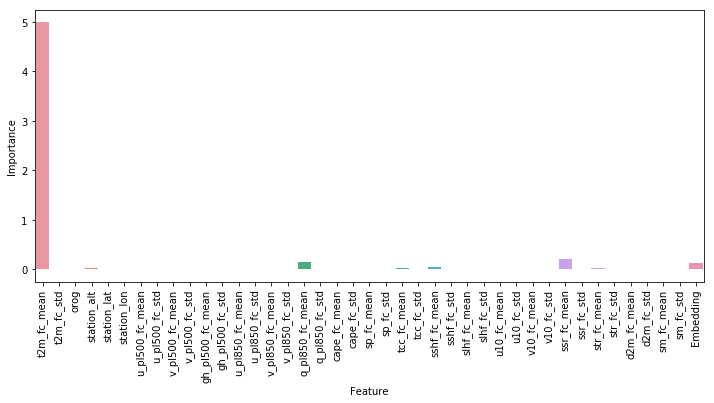

In [63]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_fc_aux_emb, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

## Neural net with hidden layer and embeddings

This is our best configuration for one year of data.

### Train the model

In [64]:
nn_aux_emb = build_emb_model(n_features, 2, [50], emb_size, max_id, compile=True, lr=0.01)

In [65]:
nn_aux_emb.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
               epochs=30, batch_size=1024, verbose=0);

In [66]:
ref_score = nn_aux_emb.evaluate([aux_test_set.features, aux_test_set.cont_ids], aux_test_set.targets, 4096, 0)
ref_score

0.8494464923622675

### Evaluate feature importance

In [67]:
fimp_nn_aux_emb = perm_imp_emb(nn_aux_emb, ref_score)

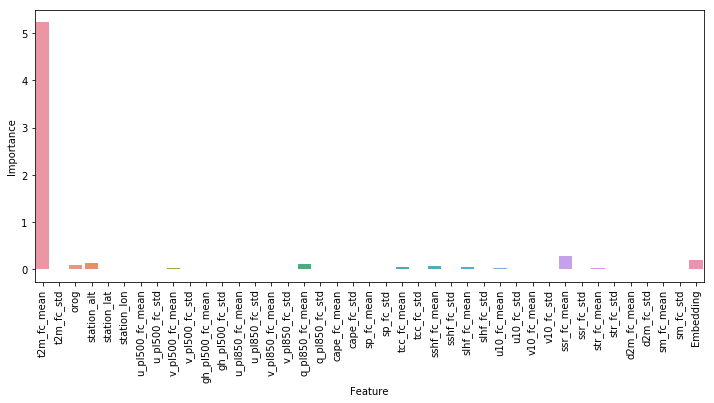

In [68]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_nn_aux_emb, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

## Compare feature importances

In [74]:
fimp_fc_aux = fimp_fc_aux.append({'Feature': 'Embedding'}, ignore_index=True)

In [76]:
fimps = [fimp_fc_aux, fimp_fc_aux_emb, fimp_nn_aux_emb]

In [80]:
mean_importance = np.nanmean([f['Importance'] for f in fimps], axis=0); mean_importance.shape

(41,)

In [84]:
for f in fimps: f['Mean importance'] = mean_importance

In [86]:
[f.sort_values('Mean importance', ascending=False, inplace=True) for f in fimps];

[None, None, None]

In [89]:
len(fimp_fc_aux)

41

<BarContainer object of 41 artists>

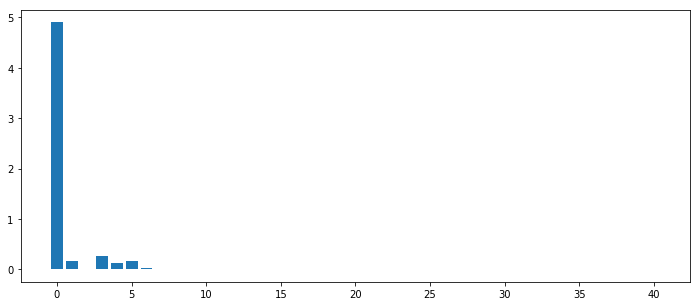

In [90]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(np.arange(41), fimp_fc_aux['Importance'])

In [95]:
comb_df = pd.DataFrame(data=fimp_fc_aux['Feature']); comb_df.head()

,Feature
0,t2m_fc_mean
32,ssr_fc_mean
40,Embedding
3,station_alt
16,q_pl850_fc_mean


In [96]:
comb_df['fc-aux'] = fimp_fc_aux['Importance']
comb_df['fc-aux-emb'] = fimp_fc_aux_emb['Importance']
comb_df['nn-aux-emb'] = fimp_nn_aux_emb['Importance']
comb_df.head()

,Feature,fc-aux,fc-aux-emb,nn-aux-emb
0,t2m_fc_mean,4.902508,4.993499,5.228206
32,ssr_fc_mean,0.167321,0.204554,0.277871
40,Embedding,NaN,0.129885,0.205059
3,station_alt,0.261028,0.032429,0.127007
16,q_pl850_fc_mean,0.125169,0.146385,0.101231


In [110]:
tmp_df = comb_df.iloc[1:15].melt(id_vars='Feature', var_name='Experiment', value_name='Importance')

In [136]:
tmp_df['Feature'] = [f.replace('_fc_', '_') for f in tmp_df['Feature']]

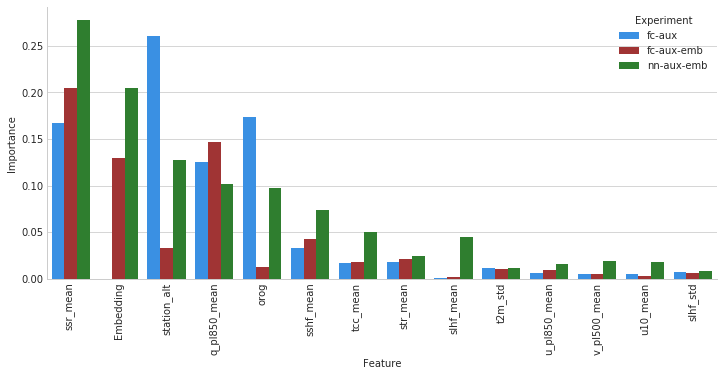

In [137]:
sns.set_style('whitegrid')
sns.set_palette(['#1E90FF', '#B22222', '#228B22'])
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data = tmp_df, x='Feature', y='Importance', hue='Experiment', ax=ax)
plt.xticks(rotation=90);
sns.despine()